In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution as de

import sys
sys.path.append("../models/")
import gr4j

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
meteo = pd.read_pickle("../data/meteo_kwbs.pkl")

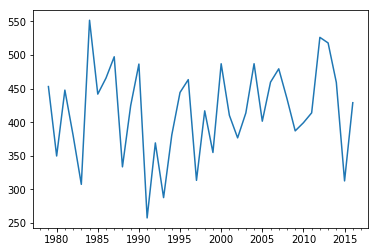

In [3]:
meteo["Prec"].resample("A").sum().plot()

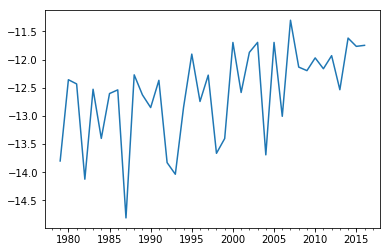

In [4]:
meteo["Temp"].resample("A").mean().plot()

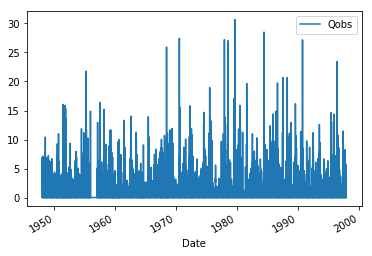

In [8]:
runoff= pd.read_pickle("../data/runoff_kwbs.pkl")

area = 21.43
coef = (86400*1000)/(area*1000000)

runoff = pd.DataFrame(runoff * coef)
runoff.columns = ["Qobs"]

runoff.plot()

In [9]:
periods = {"first"  : ["1980-01-01", "1988-12-31"], 
           "second" : ["1989-01-01", "1997-12-31"], 
           "full"   : ["1980-01-01", "1997-12-31"]}

In [10]:
def NS(obs, sim):
    
    numerator = np.nansum( (obs - sim)**2 )
    
    denominator = np.nansum( (obs - np.nanmean(obs))**2 )
    
    return 1 - numerator / denominator

In [11]:
def model_calibration(period_name, period_instance):
    
    # use meteo data
    _meteo = meteo[                   : period_instance[1]]
    
    # runoff data as a target
    Qobs   = runoff[period_instance[0]: period_instance[1]]
    
    # Define an objective function we want to minimize
    
    def objective_function(params):
        
        # calculate runoff with updated parameters
        Qsim = pd.DataFrame({"Qsim": gr4j.simulation(_meteo, params)}, index = _meteo.index)
        
        # Wrap-up simulated runoff with the observed one
        # Drop all missing values for consistency
        Q_df = pd.concat([Qsim, Qobs], axis=1).dropna()
        
        # Calculate objective function value
        # 1 - NS
        return 1 - NS(Q_df["Qobs"].values, Q_df["Qsim"].values)
    
    # The core of calibration algorithm
    ## Specify objective function
    ## Specify parameters' boundaries within lookup is running
    ## Specify parameters of the algorithm
    ### maxiter - iterations of calibration algorithm run
    ### polish  - local search of the best solution
    ### disp    - displaying progress
    ### seed    - random number seed for reproducibility
    
    result = de(objective_function, gr4j.bounds(), maxiter=50, polish=True, disp=True, seed=142)
    
    # return optimal parameters we search
    
    return result.x

In [12]:
# Create a holder for optimal model parameters

opt_pars = {}

# Run calibration routine for every period we have defined

for period_name, period_instance in periods.items():
    
    print(period_name)
    
    opt_pars[period_name] = model_calibration(period_name, period_instance)
    
print("Done!")

first
differential_evolution step 1: f(x)= 0.823183
differential_evolution step 2: f(x)= 0.823183
differential_evolution step 3: f(x)= 0.823183
differential_evolution step 4: f(x)= 0.823183
differential_evolution step 5: f(x)= 0.820534
differential_evolution step 6: f(x)= 0.818741
differential_evolution step 7: f(x)= 0.816949
differential_evolution step 8: f(x)= 0.816949
differential_evolution step 9: f(x)= 0.816949
second
differential_evolution step 1: f(x)= 0.817737
differential_evolution step 2: f(x)= 0.81059
differential_evolution step 3: f(x)= 0.8027
differential_evolution step 4: f(x)= 0.8027
differential_evolution step 5: f(x)= 0.799889
differential_evolution step 6: f(x)= 0.799889
differential_evolution step 7: f(x)= 0.799889
differential_evolution step 8: f(x)= 0.798013
differential_evolution step 9: f(x)= 0.798013
differential_evolution step 10: f(x)= 0.798013
differential_evolution step 11: f(x)= 0.795878
differential_evolution step 12: f(x)= 0.795878
differential_evolution 

In [13]:
opt_pars

{'first': array([220.19604038,   2.34236525, 210.99629325,   4.        ,
          0.25648943,   4.37585241]),
 'full': array([366.26590933,   2.21591138, 161.30983606,   0.5       ,
          0.94085865,   6.08058177]),
 'second': array([424.44953242,   2.19531952, 113.09250709,   0.5       ,
          0.92495501,   2.754537  ])}

In [17]:
opt_pars = {'first' : np.array([220.19604038,   2.34236525, 210.99629325,   4.,  0.25648943,   4.37585241]), 
            'second': np.array([424.44953242,   2.19531952, 113.09250709,   0.5, 0.92495501,   2.754537  ]), 
            'full'  : np.array([366.26590933,   2.21591138, 161.30983606,   0.5, 0.94085865,   6.08058177])}

In [18]:
# Calculate a simulated runoff and place it in the one pandas DataFrame
qsim = pd.concat([pd.DataFrame({"Qsim_{}".format(period) : gr4j.simulation(meteo, opt_pars[period])}, index = meteo.index) for period in opt_pars.keys()], axis=1)

In [19]:
# Create a helper pandas DataFrame for holding all the data together
qdf = pd.concat([qsim, runoff], axis=1)

In [20]:
# Calculate a calibration/validation matrix

## Create a holder
validation_array = np.zeros((3, 3))

## Calibration periods in rows
for i, period_name in enumerate(periods.keys()):
    
    ## Validation periods in columns
    for j, period_instance in enumerate(periods.values()):
        
        Qo = runoff[period_instance[0]: period_instance[1]]
        
        Qs = qdf["Qsim_"+period_name][period_instance[0]: period_instance[1]]
        
        Q_df = pd.concat([Qs, Qo], axis=1).dropna()
        
        validation_array[i, j] = NS(Q_df["Qobs"].values, Q_df["Qsim_"+period_name].values)
        

# Convert to a pandas DataFrame for a nice look
validation_table = pd.DataFrame(validation_array, columns=periods.keys(), index=periods.keys())

# Plot the results
validation_table

,first,second,full
first,0.184904,0.176790,0.181760
second,0.137668,0.208673,0.167374
full,0.192046,0.203880,0.197179
